<div >
<img src = "figs/dsa_banner.png" />
</div>

# Preprocesamiento

### Integrantes:
    - Catalina García García
    - Camilo Alejandro Grande Sánchez
    - Jesús Alberto Parada Pérez
    - Jorge Esteban Caballero Rodríguez


In [2]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from factor_analyzer import FactorAnalyzer

import warnings
warnings.filterwarnings("ignore")

## Carga de datos

Se cargan los datos de las fuentes dadas:

In [3]:
def cargar_datos(filename, nombre_base):
    data = pd.read_excel(f"data/{filename}")
    return data

data = cargar_datos("Base perfilación de competencias_310823.xlsx", "Base de datos:")    

##  Eliminar faltantes

Se procede a eliminar los missing en la variable regional en caso de presentarce, ya que para la fundación Future Education es un requisito saber con certeza la regional a la que pertenece un docente:

In [4]:
## Eliminar missing
data.dropna(inplace=True, subset = ["regional"])

### Imputación univariada

Se procede a corregir errores comunes en los dominios: 
- departamento: el dominio NINGUNO no es un valor valido y se debe imputar o eliminar.
- ubicacioninstitucion: la ubicación ninguna no es valida, debe ser urbana o rural
- edades: todos son docentes, maestros o agentes educativos, por lo que todos son mayores de edad; las edades 0 a 6, 7 a 14 y 15 a 17, no son validas, se debe imputar o eliminar.
- sexoinscrito: la opción Mujer no es valida, se debe reemplazar por mujer.

Esto se realizará con una imputación univariada con estrategia de la más frecuente

In [5]:
# Reemplazar los valores incorrectos con NaN
data["departamento"] = data["departamento"].replace("NINGUNO", np.nan)
data["ubicacioninstitucion"] = data["ubicacioninstitucion"].replace("ninguna", np.nan)
data["edades"] = data["edades"].replace(
    ["Entre 0 y 6 años", "Entre 7 y 14 años", "Entre 15 y 17 años"], np.nan
)
# Reemplazar los valores Mujer con mujer
data["sexoinscrito"] = data["sexoinscrito"].replace("Mujer", "mujer")

In [6]:
## Imputar con la moda
estrategia="most_frequent"

imp = SimpleImputer(missing_values=np.nan, strategy=estrategia)
imp.fit(data)
# Imputar los valores faltantes en el DataFrame
data_imputado = pd.DataFrame(imp.transform(data), columns=data.columns)

## Mapeo Respuestas

In [7]:
# Mapear las respuestas a los valores numéricos
mapeo_respuestas = {
    "Nunca": 1,
    "A veces": 2,
    "Constantemente": 3,
    "Siempre": 4
}

# Variables p1 a p20
variables_p = ['p1', 'p2', 'p3', 'p4', #Creatividad e innovación
               'p5', 'p6', 'p7', 'p8', # Resolucion de problemas
               'p9', 'p10', 'p11', 'p12', # Pensamiento critico
               'p13', 'p14', 'p15', 'p16', # Trabajo colaborativo
               'p17', 'p18', 'p19', 'p20'] # Comunicación

# Aplicar el mapeo a las columnas correspondientes
for variable in variables_p:
    data_imputado[variable] = data_imputado[variable].replace(mapeo_respuestas)

Se hace la codificación y se encuentra que el instrumento tiene preguntas inversas/negativas donde la opción `Nunca` es **Siempre**, `A veces` es **Constantemente**, `Constantemente` es **A veces**, y `Siempre` es **Nunca**.

Se procede a invertir estas preguntas.

In [8]:
# Variables que deben invertirse
variables_invertir = ["p2", "p4", "p7", "p8", "p11", "p14", "p16", "p18", "p20"]

# Invertir las respuestas en las columnas seleccionadas
for variable in variables_invertir:
    data_imputado[variable] = 5 - data_imputado[variable]  # esto "invierte" los alores

## Eliminar registros que no tienen varianza en las respuestas

Para todas las preguntas tienen la misma respuesta.

In [9]:
# Selecciona las columnas que contienen las respuestas de los docentes (p1 a p20)
respuestas = data_imputado.iloc[:, 13:33]

# Identifica respuestas constantes por docente
respuestas_constantes = respuestas.apply(pd.Series.nunique, axis=1) == 1

# Identifica patrones en zigzag por docente
patron_zigzag = ((respuestas.diff(axis=1).abs() == 1) & (respuestas.diff(axis=1).notnull())).all(axis=1)

# Marca 'Constante' en la columna 'Patron_Respuesta' si todas las respuestas son iguales
data_imputado.loc[respuestas_constantes, 'Patron_Respuesta'] = 'Constante'

# Marca 'Zigzag' en la columna 'Patron_Respuesta' si hay un patrón de zigzag en las respuestas
data_imputado.loc[patron_zigzag, 'Patron_Respuesta'] = 'Zigzag'

#Filtrar el dataframe para eliminar registros sin varianza
data_imputado = data_imputado[data_imputado['Patron_Respuesta'] != 'Constante']

## Validar que un mismo docente no tenga mas de una prueba en menos de 4 meses que dura la intervención minima de un proyecto

In [10]:
from datetime import datetime

# Asegúrate de que 'Marca temporal' sea del tipo datetime, si no lo es, conviértela
data_imputado['Marca temporal'] = pd.to_datetime(data_imputado['Marca temporal'])

# Ordenar el DataFrame por 'ID' y 'Marca temporal'
data_imputado = data_imputado.sort_values(by=['ID', 'Marca temporal'])

# Identificar pruebas realizadas por el mismo docente con menos de 6 meses de diferencia
data_imputado['Diferencia_meses'] = data_imputado.groupby('ID')['Marca temporal'].diff().dt.days // 30

# Encuentra los índices de los registros que deben ser excluidos
indices_a_eliminar = data_imputado[(data_imputado['Diferencia_meses'].lt(4) & data_imputado['Diferencia_meses'].ge(0))].index

# Elimina los registros identificados del DataFrame original
data_imputado = data_imputado.drop(indices_a_eliminar)

# Elimina la columna creada
data_imputado = data_imputado.drop(columns='Diferencia_meses')

## Analisis Factorial

Antes de implementar PCA, vamos a realizar un analisis factorial para identificar posibles patrones subyacentes en los datos que expliquen su variabilidad. Para esto primero utilizaremos el test de esfericidad de Bartlett para determinar si existe una estructura de correlación entre las variables observadas que pueda ser explotada mediante técnicas como el análisis factorial.

In [11]:
# Creando un analisis factorial, aqui utilizamos una roration ortogonal porque las variables muestran en la matriz de correlación que son independientes
fa = FactorAnalyzer(rotation='varimax')
fa.fit(data_imputado.iloc[:, 13:33])

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Contar la cantidad de eigenvalues mayores a 1
factores = sum(ev > 1)

In [12]:
# Realizar analisis factorial con tres factores (eigenvalues mayor a 1)
fa = FactorAnalyzer(n_factors=factores, rotation='varimax')
fa.fit(data_imputado.iloc[:, 13:33])

# Creando un dataframe con los pesos
loadings_dataframe = pd.DataFrame(fa.loadings_, index=variables_p)

# Función para asignar cada pregunta al factor con el loading más alto
def asignar_a_factor(loadings, variables):
    assigned_factors = {}
    for variable in variables:
        abs_loadings = np.abs(loadings.loc[variable])
        max_loading_factor = abs_loadings.idxmax()
        assigned_factors[variable] = max_loading_factor
    return assigned_factors

# Asignar cada pregunta al factor correspondiente
assigned_factors = asignar_a_factor(loadings_dataframe, variables_p)

# Crear listas de preguntas para cada factor basadas en las asignaciones
preguntas_factor = {factor: [pregunta for pregunta, asignado in assigned_factors.items() if asignado == factor] for factor in range(3)}

# Obtener loadings por factor según las asignaciones
loadings_por_factor = {}
for factor, preguntas in preguntas_factor.items():
    loadings_por_factor[factor + 1] = loadings_dataframe.loc[preguntas, factor]

# Iterar sobre los factores y sus loadings asociados
for factor, loadings in loadings_por_factor.items():
    # Multiplicar las respuestas correspondientes a cada factor por los loadings para obtener los puntajes por factor
    name_pregunta = loadings.index.tolist()  # Obtener las preguntas asociadas al factor
    data_imputado[f'Puntaje_Factor_{factor}'] = data_imputado[name_pregunta].dot(loadings)

In [13]:
# Obtener los pesos de los factores
pesos_factores = fa.get_factor_variance()[0]

# Obtener las columnas de puntajes por factor en el DataFrame
columnas_puntajes_factor = [col for col in data_imputado.columns if col.startswith('Puntaje_Factor_')]

# Multiplicar los puntajes de cada factor por sus respectivos pesos
data_imputado['Puntaje_General'] = np.sum(data_imputado[columnas_puntajes_factor] * pesos_factores[:len(columnas_puntajes_factor)], axis=1)

In [14]:
# Estandarizar los puntajes para que queden todos en una misma medida
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas de puntajes
puntajes = data_imputado[['Puntaje_Factor_1', 'Puntaje_Factor_2', 'Puntaje_Factor_3', 'Puntaje_General']]

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Estándarizar los puntajes
puntajes_estandarizados = scaler.fit_transform(puntajes)

# Agregar columnas de puntajes estandarizados al DataFrame
data_imputado['Puntaje_Factor_1_Estandarizado'] = puntajes_estandarizados[:, 0]
data_imputado['Puntaje_Factor_2_Estandarizado'] = puntajes_estandarizados[:, 1]
data_imputado['Puntaje_Factor_3_Estandarizado'] = puntajes_estandarizados[:, 2]
data_imputado['Puntaje_General_Estandarizado'] = puntajes_estandarizados[:, 3]

In [15]:
# Definir los intervalos para niveles Bajo y Alto
intervalos = [-1e10, 0, 1e10]  # Cualquier valor menor a cero es 'Bajo', igual o mayor a cero es 'Alto'
etiquetas = ['Bajo', 'Alto']

# Asignar niveles (Bajo y Alto) usando pd.cut para cada puntaje estandarizado
data_imputado["Nivel_Puntaje_Factor_1"] = pd.cut(data_imputado["Puntaje_Factor_1_Estandarizado"], bins=intervalos, labels=etiquetas)
data_imputado["Nivel_Puntaje_Factor_2"] = pd.cut(data_imputado["Puntaje_Factor_2_Estandarizado"], bins=intervalos, labels=etiquetas)
data_imputado["Nivel_Puntaje_Factor_3"] = pd.cut(data_imputado["Puntaje_Factor_3_Estandarizado"], bins=intervalos, labels=etiquetas)
data_imputado["Nivel_Puntaje_General"] = pd.cut(data_imputado["Puntaje_General_Estandarizado"], bins=intervalos, labels=etiquetas)

In [19]:
data_imputado.describe().T

,count,mean,std,min,25%,50%,75%,max
p1,4466.0,2.912450e+00,0.761440,1.000000,2.000000,3.000000,3.000000,4.000000
p2,4466.0,3.222123e+00,0.714849,1.000000,3.000000,3.000000,4.000000,4.000000
p3,4466.0,3.331169e+00,0.714464,1.000000,3.000000,3.000000,4.000000,4.000000
p4,4466.0,3.028661e+00,0.906902,1.000000,3.000000,3.000000,4.000000,4.000000
p5,4466.0,2.787282e+00,0.770381,1.000000,2.000000,3.000000,3.000000,4.000000
p6,4466.0,2.952306e+00,0.751980,1.000000,2.000000,3.000000,3.000000,4.000000
p7,4466.0,3.055307e+00,0.855696,1.000000,3.000000,3.000000,4.000000,4.000000
p8,4466.0,2.659651e+00,0.833330,1.000000,2.000000,3.000000,3.000000,4.000000
p9,4466.0,3.098074e+00,0.715693,1.000000,3.000000,3.000000,4.000000,4.000000
p10,4466.0,3.091133e+00,0.724535,1.000000,3.000000,3.000000,4.000000,4.000000


In [29]:
data_imputado = data_imputado.reset_index()

## Selección de Componentes - PCA

A partir del análisis realizado anteriormente se decidió dejar únicamente las preguntas que afectan las 12 primeras componentes las cuales son:
    ['p7', 'p12', 'p5', 'p15', 'p9', 'p2', 'p17', 'p18', 'p20', 'p6']

In [32]:
from sklearn.decomposition import PCA
# Crea el objeto PCA
pca_model = PCA(n_components=20)

# Ajusta el modelo PCA a tus datos
modelo_pca = pca_model.fit_transform(data_imputado.iloc[:, 14:34]) #tomar las 20 preguntas

# Explora la varianza explicada para determinar la cantidad óptima de componentes
explained_variance = pca_model.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Encuentra el número óptimo de componentes basado en la varianza explicada acumulativa
optimal_n_components = (cumulative_explained_variance <= 0.8).sum()+1   # Por ejemplo, puedes elegir 95% de varianza explicada

# Ajusta el modelo PCA con la cantidad óptima de componentes
pca_model = PCA(n_components=optimal_n_components)
modelo_pca = pca_model.fit_transform(data_imputado.iloc[:, 14:34])

# Calcula la varianza explicada acumulativa
explained_variance = pca_model.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)


## Modelo no supervisado de clustering con PCA

In [47]:
from sklearn.cluster import KMeans
# Aplicar K-means para agrupar los datos
kmeans = KMeans(n_clusters=2)  # Se eligen 2 clusters (Bajo y Alto)
kmeans.fit(modelo_pca)
cluster_labels = kmeans.labels_

# Crear un DataFrame con los resultados del clustering y el puntaje
cluster_df = pd.DataFrame(cluster_labels, columns=['Cluster'])
cluster_df['Puntaje'] = data_imputado['Nivel_Puntaje_General']

# Calcular la inercia de los clusters
inercia = kmeans.inertia_
print(f'Inercia de los clusters: {inercia}')

from sklearn.metrics import davies_bouldin_score

# Calcular el índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(modelo_pca, cluster_labels)
print(f'Índice de Davies-Bouldin: {davies_bouldin}')


Inercia de los clusters: 34257.0203352082
Índice de Davies-Bouldin: 2.2146162151055346


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_count(df, var1, var2):
    """Generates a Count heatmap of any two columns of a data frame

    Parameters
    ----------
    df : DataFrame
        A DataFrame that has column features
    var1 : str
        The name of a column in the DataFrame
    var2 : str
        The name of a column in the DataFrame. Different from var1

    Returns
    -------
    plot : seaborn.heatmap
        A heatmap of the 2 variables grouped by count, with preset configuration
    """

    heat_df = pd.DataFrame(df.groupby([var1, var2]).size()).reset_index()
    heat_df = heat_df.pivot(columns=var1, index=var2, values=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(heat_df, cmap="Blues", linewidths=0.5, annot=True, fmt='g')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Heatmap of {var1} vs {var2}')
    plt.show()

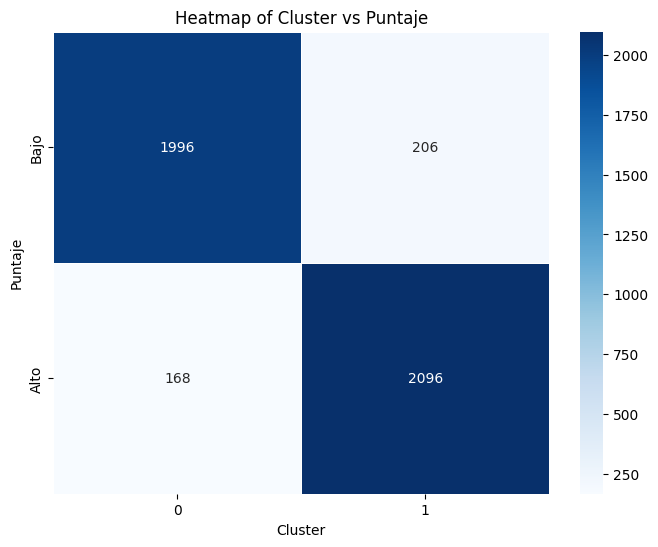

In [45]:
# Visualizar el heatmap de Cluster vs Nivel_Puntaje_General
heatmap_count(cluster_df, 'Cluster', 'Puntaje')

## Modelo Random Forest Regresor utilizando la variable a predecir que se obtuvo del analisis factorial

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Variables predictoras
col_select=['p7', 'p12', 'p5', 'p15', 'p9', 'p2', 'p17', 'p18', 'p20', 'p6']
# X = data_imputado.iloc[:, 14:34]
X = data_imputado[col_select]
# Variable a predecir
y = data_imputado["Puntaje_General_Estandarizado"]

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir la grilla de hiperparámetros a probar para el RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo de RandomForestRegressor
rf = RandomForestRegressor()

# Aplicar GridSearch para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por GridSearch
best_rf = grid_search.best_estimator_

# Calcular la puntuación del modelo en el conjunto de prueba
test_score = best_rf.score(X_test, y_test)
print(f'Puntuación del modelo en el conjunto de prueba: {test_score}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


#componentes a eliminar:
coldrops = ['p1', 'p3', 'p4', 'p8', 'p10', 'p11', 'p13', 'p14', 'p16', 'p19']

def select_comp(data):
    data_sc = data.drop(coldrops,axis=1)
    return data_sc

data_sc = select_comp(data)

## Separar y almacenar datos

Se realiza el almacenamiento de los datos y se generan bases con solo los socioeconómicos para visualización y las preguntas para los modelos

col_select=['p7', 'p12', 'p5', 'p15', 'p9', 'p2', 'p17', 'p18', 'p20', 'p6']
col_select2=['ID','p7', 'p12', 'p5', 'p15', 'p9', 'p2', 'p17', 'p18', 'p20', 'p6']
data_SE = data_imputado.drop(col_select,axis=1)
data_p = data_imputado[col_select2]

data_imputado.to_excel('data/BD_G22.xlsx')
data_p.to_excel('data/BD_G22_P.xlsx')
data_SE.to_excel('data/BD_G22_SE.xlsx')